In [1]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
import random
import math

# helps in text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# helps in model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, GlobalMaxPool1D

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle



In [2]:
#read Religion topic
religion_path = "C:/Users/stive/Documents/spam/Topic_00.en"
#save each sentence into np.array
with open(religion_path, encoding="utf8") as f:
    relig_content = [line.rstrip() for line in f]
rel_arr = np.array(relig_content)
#add for each sentence the same class (e.g.: 0)
rel_arr_label = np.full(len(rel_arr), 0)


random.seed(42)
#read all other topics
other_topic_numb = 9
max_topic_numb = 9
general_arr = []
count = 0
segments_pro_topic = math.ceil(len(rel_arr) / other_topic_numb)
while count <= max_topic_numb:
    if(count != 0):#to skip undesired topics
        general_path = f"C:/Users/stive/Documents/spam/Topic_{count:02d}.en"
        #save each sentence into np.array
        #print(segments_pro_topic)
        #save some sentences into np.array (the same amount as Religion topic ones)
        with open(general_path, encoding="utf8") as f:
            general_arr = general_arr + (random.sample([line.rstrip() for line in f], segments_pro_topic))
    count = count + 1

#print(len(general_arr))
random.shuffle(general_arr)
#add for each sentence the same class (Different from Religion! e.g.: 1)
general_arr_label = np.full(len(general_arr), 1)

conc_arr = np.concatenate((rel_arr,general_arr))
conc_arr_label = np.concatenate((rel_arr_label,general_arr_label))

In [3]:
print(len(conc_arr))
print(len(conc_arr_label))


293144
293144


In [4]:
x_train, x_test, y_train, y_test = train_test_split(conc_arr, conc_arr_label, test_size=0.20, random_state=42)

In [5]:
# prepare tokenizer, all punctuation is removed, turning the texts into space-separated sequences. These sequences are then split into lists of tokens
t = Tokenizer()
t.fit_on_texts(x_train)
#do not apply fit_on_texts to your test data

In [6]:
#encode as integers based on the learned vocabulary
encoded_train = t.texts_to_sequences(x_train)
encoded_test = t.texts_to_sequences(x_test)


In [7]:
# pad documents to a max length of the highest value
#max_length = max_value

padded_train = pad_sequences(encoded_train, padding='post')#maxlen=max_length
padded_test = pad_sequences(encoded_test, padding='post') #maxlen=max_length


In [8]:
vocab_size = len(t.word_index) + 1
## some config values
embed_size = 100 # how big is each word vector
max_features = 44971 # how many unique words to use (i.e num rows in embedding vector)
n_lstm = 20
drop_lstm =0.2

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 20))#input_length=max_length
model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          2044700   
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          3280      
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 500)               10500     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [9]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# fit the model
model.fit(x=padded_train,
         y=y_train,
         epochs=5,
         validation_data=(padded_test, y_test), verbose=1,
         callbacks=[early_stop]
         )

Epoch 1/5
7329/7329 [==============================] - 1741s 229ms/step - loss: 0.1922 - accuracy: 0.9202 - val_loss: 0.1624 - val_accuracy: 0.9288
Epoch 2/5
7329/7329 [==============================] - 1679s 229ms/step - loss: 0.1551 - accuracy: 0.9393 - val_loss: 0.1474 - val_accuracy: 0.9379
Epoch 3/5
7329/7329 [==============================] - 1611s 220ms/step - loss: 0.1502 - accuracy: 0.9409 - val_loss: 0.1461 - val_accuracy: 0.9418
Epoch 4/5
7329/7329 [==============================] - 1638s 223ms/step - loss: 0.1482 - accuracy: 0.9427 - val_loss: 0.1470 - val_accuracy: 0.9412
Epoch 5/5
7329/7329 [==============================] - 1661s 227ms/step - loss: 0.1472 - accuracy: 0.9447 - val_loss: 0.1659 - val_accuracy: 0.9410
Epoch 00005: early stopping


In [10]:
#Metrics

def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print("Accuracy : "+ str(acc_sc))
   return acc_sc

def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, 
               cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')

In [11]:
preds = (model.predict(padded_test) > 0.5).astype("int32")


In [12]:
c_report(y_test, preds)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     29303
           1       0.96      0.92      0.94     29326

    accuracy                           0.94     58629
   macro avg       0.94      0.94      0.94     58629
weighted avg       0.94      0.94      0.94     58629

Accuracy : 0.940967780449948


0.940967780449948

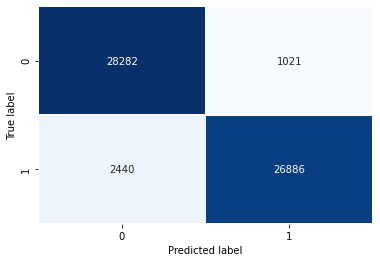

In [13]:
plot_confusion_matrix(y_test, preds)

In [14]:
model.save("spam_model_2")

INFO:tensorflow:Assets written to: spam_model_5\assets


INFO:tensorflow:Assets written to: spam_model_5\assets


In [16]:
from tensorflow.keras.models import load_model
print("[INFO] loading pre-trained network...")
#load model
s_model = tf.keras.models.load_model("spam_model_2")
print(s_model.summary())
#The second dimension of the input/embedding layer should match the lenght of the pad sequences


In [ ]:
pred = None
test_arr_label= None
index = None
j = None
test_arr = None


In [17]:
#Change max_len according to the shape of the input/embedding layer (second dimension of the summary printer before)


def predict_spam(predict_msg):
    with open(predict_msg, encoding="utf8") as f:
        test_content = [line.rstrip() for line in f]
    global test_arr    
    test_arr = np.array(test_content)
    global test_arr_label
    #test_arr_label = np.full(len(test_arr), 1)
    t = Tokenizer()
    max_len = 20
    test_proc = t.texts_to_sequences((o)for o in test_arr)
    test_proc = pad_sequences(test_proc, maxlen=max_len, padding='post')
    
    #print(test_proc.shape)
    global pred
    pred = (s_model.predict(test_proc) > 0.1).astype("int32")
    return pred
    global index, j
    index, j = np.where(pred == 0)
    print(index)
    print(j)
    print(len(index))
    print(len(j))

    
    selection = [test_arr[ind] for ind in index]
    print(selection[:10])
    
    with open('C:/Users/stive/Documents/spamwrong_rel_es.txt', 'w') as f:
        for sel in selection:
            print (sel)
            f.write("%s\n" % str(sel))

    
predict_spam("C:/Users/stive/Documents/spam/08_mixedSites.en")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          2044700   
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          3280      
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 500)               10500     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [18]:
#Separate individual test
test_path = "C:/Users/stive/Documents/spam/Topic_02.en"
#save each sentence into np.array
with open(test_path, encoding="utf8") as f:
    test_content = [line.rstrip() for line in f]
test_arr = np.array(test_content)
#add for each sentence the same class (e.g.: 0)
test_arr_label = np.full(len(test_arr), 1)



In [19]:
#print(test_arr[:10])
#print(len(test_arr))

In [21]:
test_proc = t.texts_to_sequences((o)for o in test_arr)
#print(test_proc[:10])
#print(len(test_proc))


In [22]:
test_proc = pad_sequences(test_proc, padding='post')
#print(test_proc[:2])
#print(type(test_proc))

In [23]:
print(test_proc.shape)

#print(test_proc)
#print(len(test_proc))
#print(type(test_proc))

(37804, 171)


In [24]:
pred = (model.predict(test_proc) > 0.1).astype("int32")

In [ ]:
#print(pred[:10])

In [25]:
c_report(test_arr_label, pred)

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     37804

    accuracy                           1.00     37804
   macro avg       0.50      0.50      0.50     37804
weighted avg       1.00      1.00      1.00     37804

Accuracy : 0.9979631784996297


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9979631784996297

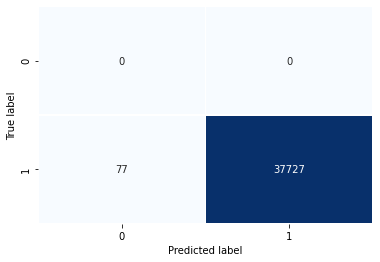

In [26]:
plot_confusion_matrix(test_arr_label, pred)

In [ ]:
#To set other metrics
#from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
#y_predict  = [1 if o>0.5 else 0 for o in model.predict(test_proc)]

In [27]:
index, j = np.where(pred == 0)
print(index)
print(j)
print(len(index))
print(len(j))


selection = [test_arr[ind] for ind in index]
print(selection[:10])

#print(test_arr[:10])

[  598   844  1258  1563  3666  3735  3958  5889  6414  6762  7909  8055
  9138  9333  9989 10564 10749 10785 11152 11189 11775 11902 12366 12396
 13080 14609 15196 15307 16235 16388 16702 16808 17531 20927 20986 21006
 21041 21169 21323 21409 21734 21822 21920 23220 23441 23997 24203 24358
 24902 25470 25863 25987 26473 27839 28369 28541 29021 29137 29170 29179
 30250 30476 31222 31391 31635 31911 32272 33830 33989 34163 34618 35183
 35871 36082 36130 36445 36660]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
77
77
['For I am elderly, and my wife is advanced in years.”', 'Follow your passion and do something you love, visit our fitness trainer certs and be a fully certified personal trainer.', '31:22 He who surrenders himself to Allah and is a good doer, has grasped the firmest handle.', '5.Fitting for all men and women of adults and elderly both right and left Ears', 'Scold